# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-03-04 08:49:37.240364: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 08:49:37.242069: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 08:49:37.269732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 08:49:37.269758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 08:49:37.270384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Vanishing/Exploding Gradients Problem

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

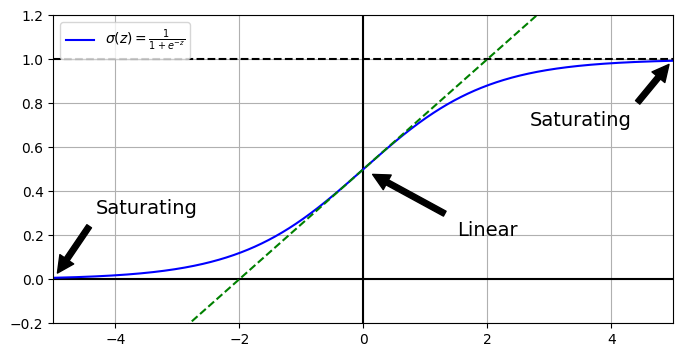

In [3]:
z = np.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 4))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot(z, sigmoid(z), "b-", label=r"$\sigma(z) = \frac{1}{1 + e^{-z}}$")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Saturating",
    xytext=(3.5, 0.7),
    xy=(5, 1),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Saturating",
    xytext=(-3.5, 0.3),
    xy=(-5, 0),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center"
)
plt.grid()
plt.legend(loc="upper left")
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Xavier and He initialization                

You can switch to your desired initialization by setting the `kernel_initializer` hyperparameter.

In [4]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

If you want to use He initialization with a uniform distribution and based on $fan_{avg}$ instead of $fan_{in}$, you can use the `VarianceScaling` initializer.

In [5]:
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_avg", distribution="uniform"
)
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

## Non-saturating Activation Functions

### Leaky ReLU

In [6]:
def leaky_relu(z, alpha):
    return np.maximum(z, alpha * z)

(-5.0, 5.0, -1.0, 4.0)

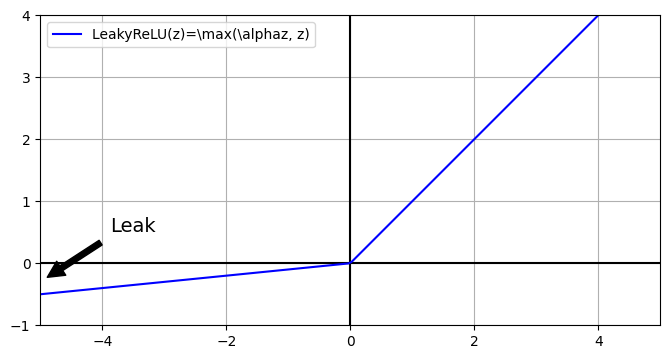

In [7]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=((8, 5)))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, leaky_relu(z, 0.1), "b-", label=r"LeakyReLU(z)=\max(\alphaz, z)")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Leak",
    xy=(-5, -0.3),
    xytext=(-3.5, 0.5),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.gca().set_aspect("equal")
plt.grid()
plt.legend()
plt.axis([-5, 5, -1, 4])

In [8]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")

In [9]:
model = tf.keras.Sequential(
    [
        # some layers
        tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
        tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
        # more layers
    ]
)

### ELU and SELU

- We reimplement the SELU using the coefficient in the paper. <br>
- Note that `erfc(x)` function stands for Complementary Error Function, which is defined as `1-rfc(x)`, where `erf(x)` is the Error Function.<br>
- The formula of `erf()` is:
$$\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}$$
- `erfc(x)` is related to the cumulative distribution function (CDF) of a standard normal distribution:
$$erfc\left(\frac{x}{\sqrt{2}}\right)=2 \times CDF(-x) $$

In [10]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e**2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    )
    ** (-1 / 2)
)


def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)


def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [11]:
scale_0_1

1.0507009873554805

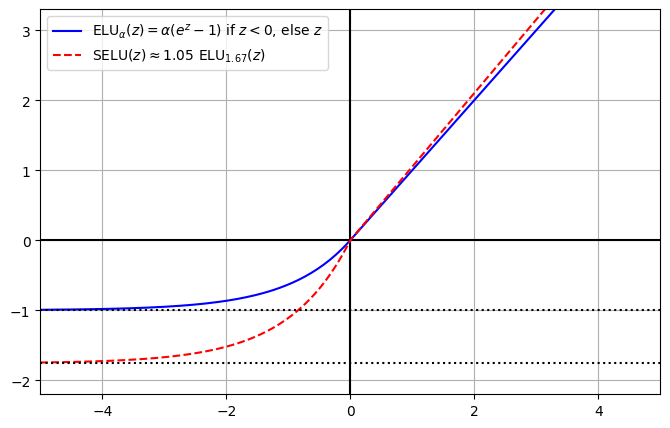

In [12]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(8, 5))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, elu(z), "b-", label=r"ELU$_\alpha(z)=\alpha(e^z-1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", label=r"SELU$(z)\approx1.05 \ $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [-1, -1], "k:")
plt.plot([-5, 5], [-scale_0_1 * alpha_0_1, -scale_0_1 * alpha_0_1], "k:")
plt.legend()
plt.grid()
plt.axis([-5, 5, -2.2, 3.3])
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization.

In [13]:
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")

Similarly, using SELU is straightforward.

In [14]:
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")

**Extra material - an example of a self-regularized network using SELU**

Here we create a neural network for Fashion MNIST with 100 hidden layers, using the SELU activation function.

In [15]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

Now let's train it. Do not forget to scale the input to mean 0 and standard deviation 1.

In [17]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

In [18]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [19]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [20]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 21s 11ms/step - loss: 1.1073 - accuracy: 0.5787 - val_loss: 0.8289 - val_accuracy: 0.7112
Epoch 2/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.8936 - accuracy: 0.6830 - val_loss: 1.0647 - val_accuracy: 0.6006
Epoch 3/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.7591 - accuracy: 0.7215 - val_loss: 0.6604 - val_accuracy: 0.7638
Epoch 4/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.6462 - accuracy: 0.7629 - val_loss: 0.5956 - val_accuracy: 0.7926
Epoch 5/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.7859 - accuracy: 0.7145 - val_loss: 0.6322 - val_accuracy: 0.7672


The network managed to learn, despite how deep it is. Now look at what happened if we try to use the ReLU activation function instead.

In [21]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

In [23]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 20s 10ms/step - loss: 1.9645 - accuracy: 0.2096 - val_loss: 1.6799 - val_accuracy: 0.3244
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 1.5111 - accuracy: 0.3430 - val_loss: 1.3787 - val_accuracy: 0.4620
Epoch 3/5
1719/1719 [==============================] - 16s 9ms/step - loss: 1.1604 - accuracy: 0.5168 - val_loss: 1.0453 - val_accuracy: 0.5798
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8956 - accuracy: 0.6465 - val_loss: 0.8343 - val_accuracy: 0.6856
Epoch 5/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.8294 - accuracy: 0.6723 - val_loss: 0.7495 - val_accuracy: 0.7024


Not so great, we suffer from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

In [24]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)


def approx_gelu(z):
    return swish(z, beta=1.702)


def softplus(z):
    return np.log(np.exp(z) + 1)


def mish(z):
    return z * np.tanh(softplus(z))

Text(0.5, 0, 'z')

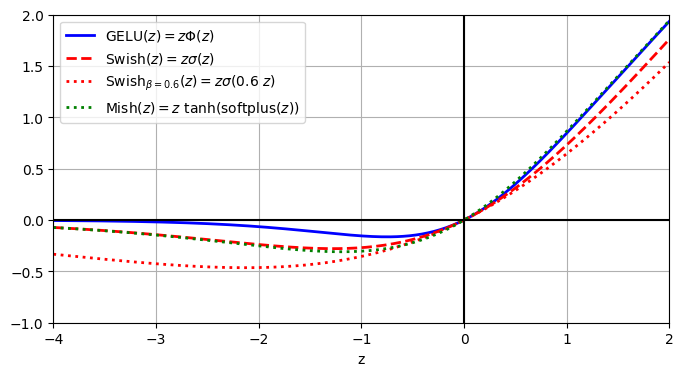

In [25]:
z = np.linspace(-4, 2, 200)

beta = 0.6
plt.figure(figsize=(8, 4))
plt.plot(z, approx_gelu(z), "b-", linewidth=2, label=r"GELU$(z)=z\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2, label=r"Swish$(z)=z\sigma(z)$")
plt.plot(
    z,
    swish(z, 0.6),
    "r:",
    linewidth=2,
    label=rf"Swish$_{{\beta={beta}}}(z)=z\sigma({beta} \ z)$",
)
plt.plot(z, mish(z), "g:", linewidth=2, label=r"Mish$(z)=z \ \tanh($softplus$(z))$")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-5, 5], "k-")
plt.legend()
plt.grid()
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("z")

# Batch Normalization

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [27]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In this tiny example, just two hidden layers batch normalization is unlikely to make a huge impact, but ofr deeper network it can have a tremendous difference.

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

Let's look at the parameters of the first BN layer:

In [29]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [30]:
# Extra code - just to verify that the model works
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5571 - accuracy: 0.8076 - val_loss: 0.3987 - val_accuracy: 0.8580
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4059 - accuracy: 0.8554 - val_loss: 0.3639 - val_accuracy: 0.8702


In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [32]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [33]:
# Extra code - just to verify that the model works
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

1719/1719 [==============================] - 6s 3ms/step - loss: 0.6035 - accuracy: 0.7990 - val_loss: 0.4351 - val_accuracy: 0.8418


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` argument.

In [34]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [35]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Transfer Learning with Keras

In [36]:
sandal_idx = class_names.index("Pullover")
shirt_idx = class_names.index("T-shirt/top")


def split_dataset(X, y):
    # Here, as the model B contains only 2 classes, we assume the positive class is the sandal class and the negative class is the shirt class
    y_for_B = (y == sandal_idx) | (y == shirt_idx)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == sandal_idx).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([sandal_idx, shirt_idx]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return (X[~y_for_B], y_A), (X[y_for_B], y_B)


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [37]:
tf.random.set_seed(42)
model_A = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="softmax"),
    ]
)
model_A.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model.fit(
    X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A)
)
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 5s 3ms/step - loss: 0.5911 - val_loss: 0.3010
Epoch 2/20
1376/1376 [==============================] - 3s 3ms/step - loss: 0.3011 - val_loss: 0.2614
Epoch 3/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.2659 - val_loss: 0.2464
Epoch 4/20
1376/1376 [==============================] - 5s 3ms/step - loss: 0.2404 - val_loss: 0.2332
Epoch 5/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.2238 - val_loss: 0.2310
Epoch 6/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.2127 - val_loss: 0.2234
Epoch 7/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.1998 - val_loss: 0.2172
Epoch 8/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.1910 - val_loss: 0.2216
Epoch 9/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.1837 - val_loss: 0.2142
Epoch 10/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.174

INFO:tensorflow:Assets written to: my_model_A/assets


In [38]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model_B.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model_B.fit(
    X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B)
)
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 22ms/step - loss: 0.8218 - accuracy: 0.5450 - val_loss: 0.8048 - val_accuracy: 0.5124
Epoch 2/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7665 - accuracy: 0.5450 - val_loss: 0.7622 - val_accuracy: 0.5124
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.7311 - accuracy: 0.5400 - val_loss: 0.7344 - val_accuracy: 0.5183
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.7053 - accuracy: 0.5500 - val_loss: 0.7104 - val_accuracy: 0.5420
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 0.6839 - accuracy: 0.5700 - val_loss: 0.6889 - val_accuracy: 0.5796
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.6640 - accuracy: 0.6250 - val_loss: 0.6699 - val_accuracy: 0.6281
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6463 - accuracy: 0.6700 - val_loss: 0.6534 - val_accuracy: 0.6894
Epoch 8/20
7/7 [===============

[0.5242629647254944, 0.887499988079071]

Model B reached 93.80% accuracy on the test set. Now let's try reusing the pretrained model A.

In [39]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so if we train one, it will update both models. If we want to avoid this, we need to build `model_B_on_A` on top of a *clone* of `model_A`.

In [40]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [42]:
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B)
)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B)
)

Epoch 1/4
7/7 [==============================] - 0s 22ms/step - loss: 0.6028 - accuracy: 0.8150 - val_loss: 0.6178 - val_accuracy: 0.7864
Epoch 2/4
7/7 [==============================] - 0s 11ms/step - loss: 0.6020 - accuracy: 0.8100 - val_loss: 0.6171 - val_accuracy: 0.7854
Epoch 3/4
7/7 [==============================] - 0s 9ms/step - loss: 0.6011 - accuracy: 0.8100 - val_loss: 0.6163 - val_accuracy: 0.7933
Epoch 4/4
7/7 [==============================] - 0s 9ms/step - loss: 0.5997 - accuracy: 0.8200 - val_loss: 0.6156 - val_accuracy: 0.7953
Epoch 1/16
7/7 [==============================] - 0s 21ms/step - loss: 0.5915 - accuracy: 0.8200 - val_loss: 0.5970 - val_accuracy: 0.8318
Epoch 2/16
7/7 [==============================] - 0s 9ms/step - loss: 0.5724 - accuracy: 0.8350 - val_loss: 0.5796 - val_accuracy: 0.8497
Epoch 3/16
7/7 [==============================] - 0s 10ms/step - loss: 0.5545 - accuracy: 0.8650 - val_loss: 0.5639 - val_accuracy: 0.8477
Epoch 4/16
7/7 [==================

So what's the final verdict?

In [43]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.9005


[0.42975136637687683, 0.9004999995231628]

Well, to our surprise, the model's performance actually drops! The full explanation is in the note.md. 

# Faster Optimizers

In [44]:
# Build some help function to test an optimizer on Fashion MNIST


def build_model(seed: int = 42):
    tf.random.set_seed(42)
    return tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[28, 28]),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(100, activation="softmax"),
        ]
    )


def build_and_train_model(
    optimizer: tf.keras.optimizers.Optimizer,
) -> tf.keras.callbacks.History:
    model = build_model()
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    return model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

In [45]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [46]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8153 - accuracy: 0.7307 - val_loss: 0.5135 - val_accuracy: 0.8246
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4912 - accuracy: 0.8282 - val_loss: 0.4573 - val_accuracy: 0.8390
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4396 - accuracy: 0.8458 - val_loss: 0.4181 - val_accuracy: 0.8530
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4097 - accuracy: 0.8575 - val_loss: 0.3921 - val_accuracy: 0.8578
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3868 - accuracy: 0.8642 - val_loss: 0.3809 - val_accuracy: 0.8626
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3717 - accuracy: 0.8688 - val_loss: 0.3813 - val_accuracy: 0.8622
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3553 - accuracy: 0.8735 - val_loss: 0.3712 - val_accuracy:

## Momentum optimization

In [47]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [48]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7970 - accuracy: 0.7388 - val_loss: 0.5163 - val_accuracy: 0.8202
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4851 - accuracy: 0.8301 - val_loss: 0.4610 - val_accuracy: 0.8322
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4346 - accuracy: 0.8473 - val_loss: 0.4205 - val_accuracy: 0.8502
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4055 - accuracy: 0.8568 - val_loss: 0.3906 - val_accuracy: 0.8588
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3820 - accuracy: 0.8650 - val_loss: 0.3744 - val_accuracy: 0.8632
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3675 - accuracy: 0.8685 - val_loss: 0.3780 - val_accuracy: 0.8626
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3513 - accuracy: 0.8742 - val_loss: 0.3775 - val_accuracy:

## Nesterov Accelerated Gradient

To use NAG, set the `nesterov` hyperparameter to `True`.

In [49]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [50]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7920 - accuracy: 0.7459 - val_loss: 0.5095 - val_accuracy: 0.8160
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4823 - accuracy: 0.8309 - val_loss: 0.4515 - val_accuracy: 0.8336
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4352 - accuracy: 0.8451 - val_loss: 0.4285 - val_accuracy: 0.8472
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4077 - accuracy: 0.8565 - val_loss: 0.3916 - val_accuracy: 0.8550
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3855 - accuracy: 0.8630 - val_loss: 0.3804 - val_accuracy: 0.8600
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3704 - accuracy: 0.8681 - val_loss: 0.3815 - val_accuracy: 0.8654
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3547 - accuracy: 0.8731 - val_loss: 0.3844 - val_accuracy:

## AdaGrad

**Note**: Even though Keras does have an `Adagrad` optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks, such as linear regression, though).

In [51]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [52]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.4156 - accuracy: 0.6259 - val_loss: 0.8071 - val_accuracy: 0.7512
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7333 - accuracy: 0.7604 - val_loss: 0.6591 - val_accuracy: 0.7852
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6405 - accuracy: 0.7875 - val_loss: 0.6002 - val_accuracy: 0.8012
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5952 - accuracy: 0.8027 - val_loss: 0.5666 - val_accuracy: 0.8112
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5652 - accuracy: 0.8119 - val_loss: 0.5431 - val_accuracy: 0.8190
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5434 - accuracy: 0.8183 - val_loss: 0.5270 - val_accuracy: 0.8222
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5269 - accuracy: 0.8227 - val_loss: 0.5104 - val_accuracy:

## RMSProp

In [53]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [54]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5335 - accuracy: 0.8086 - val_loss: 0.4241 - val_accuracy: 0.8456
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3950 - accuracy: 0.8574 - val_loss: 0.4467 - val_accuracy: 0.8302
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3639 - accuracy: 0.8705 - val_loss: 0.4060 - val_accuracy: 0.8588
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3584 - accuracy: 0.8746 - val_loss: 0.3766 - val_accuracy: 0.8718
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3537 - accuracy: 0.8757 - val_loss: 0.4405 - val_accuracy: 0.8452
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3487 - accuracy: 0.8782 - val_loss: 0.4498 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3489 - accuracy: 0.8782 - val_loss: 0.4441 - val_accuracy:

## Adam

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [56]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5371 - accuracy: 0.8124 - val_loss: 0.4280 - val_accuracy: 0.8400
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3817 - accuracy: 0.8613 - val_loss: 0.3800 - val_accuracy: 0.8614
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3477 - accuracy: 0.8712 - val_loss: 0.3593 - val_accuracy: 0.8692
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3219 - accuracy: 0.8806 - val_loss: 0.3406 - val_accuracy: 0.8768
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3013 - accuracy: 0.8891 - val_loss: 0.3296 - val_accuracy: 0.8768
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2871 - accuracy: 0.8933 - val_loss: 0.3349 - val_accuracy: 0.8818
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2741 - accuracy: 0.8957 - val_loss: 0.3405 - val_accuracy:

### AdaMax optimization

In [57]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [58]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5785 - accuracy: 0.8073 - val_loss: 0.4669 - val_accuracy: 0.8274
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4091 - accuracy: 0.8542 - val_loss: 0.3934 - val_accuracy: 0.8542
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3696 - accuracy: 0.8674 - val_loss: 0.3665 - val_accuracy: 0.8682
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3438 - accuracy: 0.8769 - val_loss: 0.3489 - val_accuracy: 0.8732
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3224 - accuracy: 0.8823 - val_loss: 0.3339 - val_accuracy: 0.8790
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3082 - accuracy: 0.8884 - val_loss: 0.3418 - val_accuracy: 0.8740
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2937 - accuracy: 0.8924 - val_loss: 0.3453 - val_accuracy:

### Nadam optimization

In [59]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [60]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5136 - accuracy: 0.8211 - val_loss: 0.4246 - val_accuracy: 0.8402
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3705 - accuracy: 0.8652 - val_loss: 0.3963 - val_accuracy: 0.8510
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3348 - accuracy: 0.8775 - val_loss: 0.3400 - val_accuracy: 0.8774
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3135 - accuracy: 0.8847 - val_loss: 0.3397 - val_accuracy: 0.8776
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2948 - accuracy: 0.8903 - val_loss: 0.3382 - val_accuracy: 0.8722
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2799 - accuracy: 0.8964 - val_loss: 0.3768 - val_accuracy: 0.8730
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2691 - accuracy: 0.8990 - val_loss: 0.3639 - val_accuracy:

### AdamW optimization

**Note**: Since TF 1.12, `AdamW` is no longer experimental. It is available at `tf.keras.optimizers.AdamW`, instead of `tf.keras.optimizers.experimental.AdamW`.

In [61]:
optimizer = tf.keras.optimizers.AdamW(
    weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999
)

In [62]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5306 - accuracy: 0.8145 - val_loss: 0.4179 - val_accuracy: 0.8408
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3776 - accuracy: 0.8618 - val_loss: 0.3954 - val_accuracy: 0.8464
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3433 - accuracy: 0.8732 - val_loss: 0.3495 - val_accuracy: 0.8800
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3206 - accuracy: 0.8815 - val_loss: 0.3373 - val_accuracy: 0.8774
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3001 - accuracy: 0.8876 - val_loss: 0.3251 - val_accuracy: 0.8796
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2868 - accuracy: 0.8942 - val_loss: 0.3444 - val_accuracy: 0.8766
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2734 - accuracy: 0.8974 - val_loss: 0.3361 - val_accuracy:

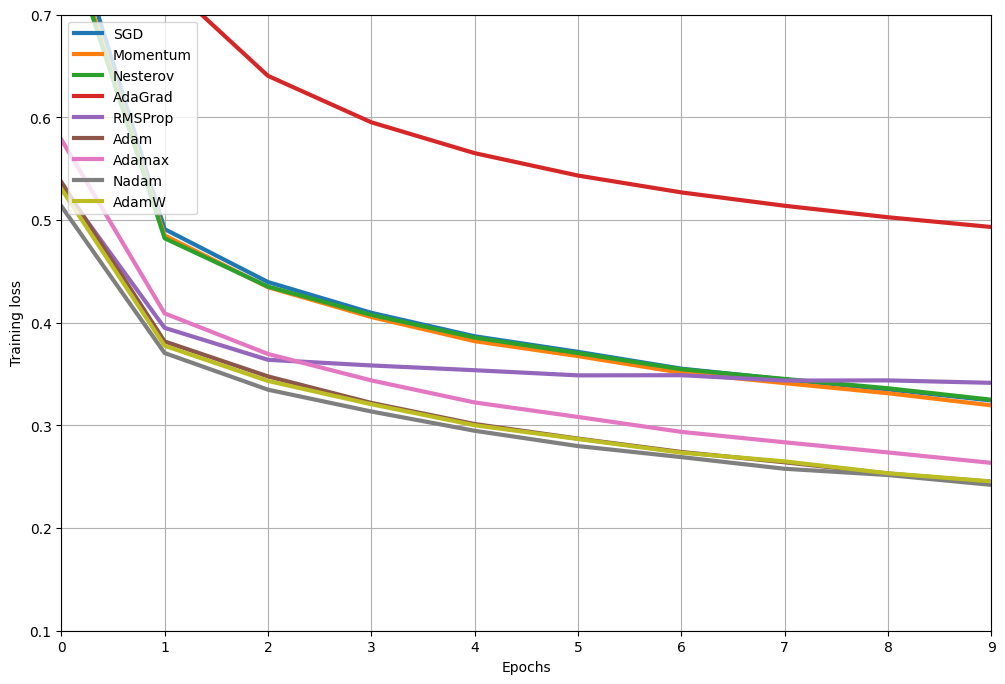

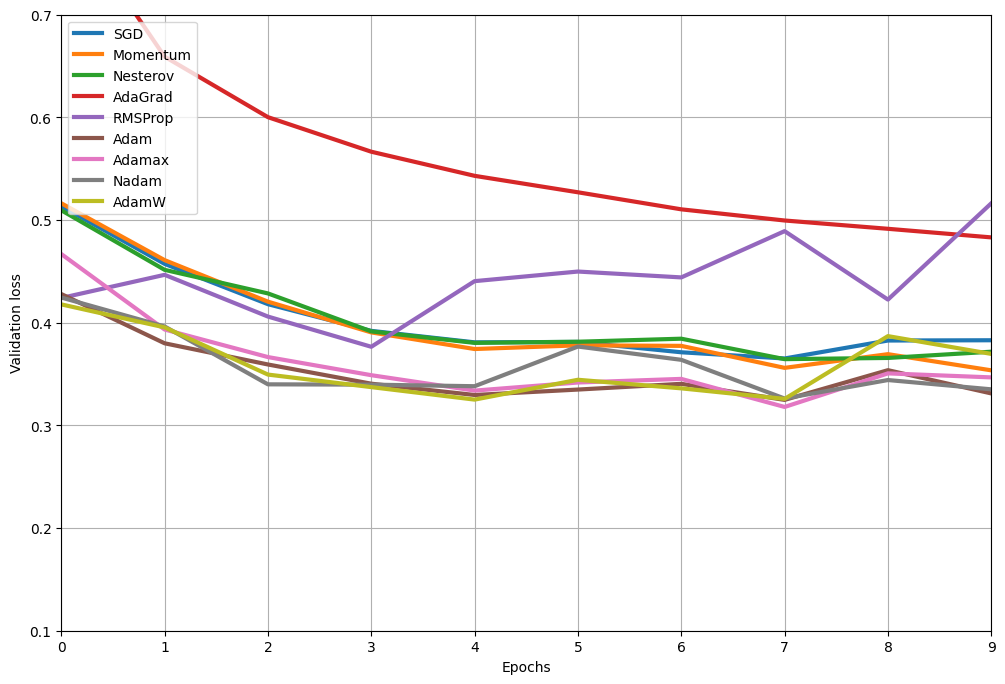

In [63]:
# Extra code to visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    optimizers_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, optimizer_name in zip(
        (
            history_sgd,
            history_momentum,
            history_nesterov,
            history_adagrad,
            history_rmsprop,
            history_adam,
            history_adamax,
            history_nadam,
            history_adamw,
        ),
        optimizers_names.split(),
    ):
        plt.plot(history.history[loss], label=f"{optimizer_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    if loss == "loss":
        plt.ylabel("Training loss")
    if loss == "val_loss":
        plt.ylabel("Validation loss")
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```python
learning_rate = initial_learning_rate / (1 + step / decay_steps) ** power
```
Keras uses `power=1`.

**Note**: The `decay` argument in optimizers is deprecated. The old optimizers which implements the `decay` argument are still available in `tf.keras.optimizers.legacy`, but you should use the schedulers in `tf.keras.optimizers.schedules` instead.

In [64]:
# Deprecated:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [65]:
# Recommended
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01, decay_steps=10_000, decay_rate=1.0, staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_scheduler)

The `InverseTimeDecay` scheduler uses `learning_rate=initial_learning_rate / (1 + decay_rate * step / decay_steps)`. If you set `staircase=True`, then it replaces `step / decay_steps` with `floor(step / decay_steps)`.

In [66]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8000 - accuracy: 0.7391 - val_loss: 0.5063 - val_accuracy: 0.8166
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4926 - accuracy: 0.8248 - val_loss: 0.4611 - val_accuracy: 0.8306
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4428 - accuracy: 0.8435 - val_loss: 0.4215 - val_accuracy: 0.8512
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4182 - accuracy: 0.8507 - val_loss: 0.3970 - val_accuracy: 0.8570
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3981 - accuracy: 0.8592 - val_loss: 0.3965 - val_accuracy: 0.8576
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3831 - accuracy: 0.8630 - val_loss: 0.3969 - val_accuracy: 0.8588
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3719 - accuracy: 0.8660 - val_loss: 0.3805 - val_accuracy:

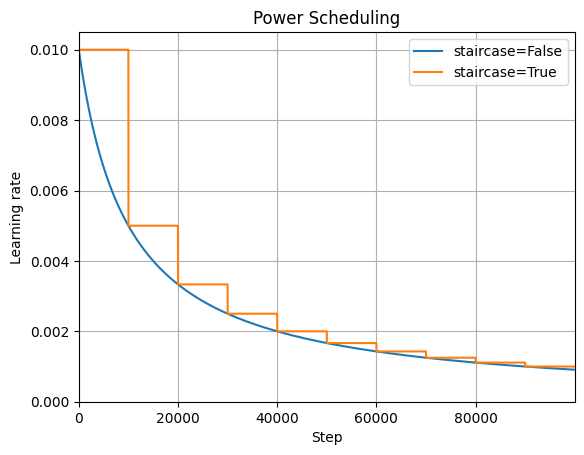

In [67]:
initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * (steps / decay_steps))
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs, "-", label="staircase=False")
plt.plot(steps, lrs2, "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.title("Power Scheduling")
plt.legend()
plt.grid()
plt.show()

### Exponential Scheduling

`learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)`

In [68]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=20_000, decay_rate=0.1, staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_scheduler)

In [69]:
history_exponential_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7956 - accuracy: 0.7373 - val_loss: 0.5083 - val_accuracy: 0.8240
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4967 - accuracy: 0.8266 - val_loss: 0.4848 - val_accuracy: 0.8260
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4478 - accuracy: 0.8418 - val_loss: 0.4335 - val_accuracy: 0.8486
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4242 - accuracy: 0.8514 - val_loss: 0.4139 - val_accuracy: 0.8556
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4057 - accuracy: 0.8571 - val_loss: 0.4075 - val_accuracy: 0.8528
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3927 - accuracy: 0.8618 - val_loss: 0.4120 - val_accuracy: 0.8502
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3836 - accuracy: 0.8643 - val_loss: 0.3952 - val_accuracy:

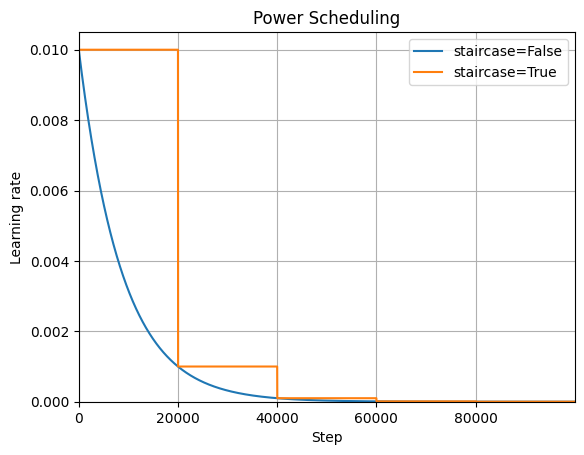

In [70]:
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs, "-", label="staircase=False")
plt.plot(steps, lrs2, "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.title("Power Scheduling")
plt.legend()
plt.grid()
plt.show()

Keras also provides a `LearningRateScheduler` callback class that let you define your own scheduling function. Here is how you could use it to implement exponential decay. <br>
Not that in this case, the learning rate only changes at each epoch, not at each step.

In [71]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [72]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [73]:
tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [74]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7749 - accuracy: 0.7403 - val_loss: 0.5001 - val_accuracy: 0.8272 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4855 - accuracy: 0.8287 - val_loss: 0.4572 - val_accuracy: 0.8348 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4349 - accuracy: 0.8455 - val_loss: 0.4268 - val_accuracy: 0.8502 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4094 - accuracy: 0.8553 - val_loss: 0.3970 - val_accuracy: 0.8596 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3900 - accuracy: 0.8621 - val_loss: 0.3976 - val_accuracy: 0.8574 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3750 - accuracy: 0.8668 - val_loss: 0.3975 - val_accuracy: 0.8612 - lr: 0.0056
Epoch 7/20
1719/1719 [==============================] - 3s

Alternatively, the schedule function can take the current learning rate as a second argument.

In [75]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [76]:
K = tf.keras.backend


class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at every epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.learning_rate)

In [77]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [78]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[exp_decay],
)

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8018 - accuracy: 0.7368 - val_loss: 0.5162 - val_accuracy: 0.8176 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4989 - accuracy: 0.8240 - val_loss: 0.4888 - val_accuracy: 0.8224 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4468 - accuracy: 0.8403 - val_loss: 0.4317 - val_accuracy: 0.8460 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4197 - accuracy: 0.8511 - val_loss: 0.4053 - val_accuracy: 0.8558 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3984 - accuracy: 0.8591 - val_loss: 0.3955 - val_accuracy: 0.8576 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3826 - accuracy: 0.8629 - val_loss: 0.4035 - val_accuracy: 0.8564 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 3s

### Piecewise Constant Scheduling

In [79]:
lr_scheduler = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000], values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_scheduler)

In [80]:
history_piecewise_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8154 - accuracy: 0.7288 - val_loss: 0.5008 - val_accuracy: 0.8258
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4977 - accuracy: 0.8252 - val_loss: 0.4738 - val_accuracy: 0.8270
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4418 - accuracy: 0.8436 - val_loss: 0.4402 - val_accuracy: 0.8482
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4125 - accuracy: 0.8549 - val_loss: 0.3981 - val_accuracy: 0.8580
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3892 - accuracy: 0.8619 - val_loss: 0.3870 - val_accuracy: 0.8620
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3711 - accuracy: 0.8679 - val_loss: 0.3922 - val_accuracy: 0.8578
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3575 - accuracy: 0.8706 - val_loss: 0.3600 - val_accuracy:

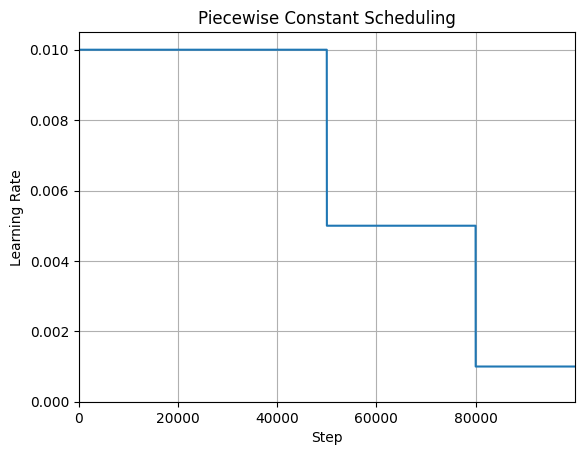

In [81]:
boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling")
plt.grid()
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually.

In [82]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    if epoch < 15:
        return 0.005
    else:
        return 0.001

In [83]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)

    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]

    return piecewise_constant_fn


piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [84]:
# Extra code - use a tf.keras.callbacks.LearningRateScheduler as earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/25
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5488 - accuracy: 0.8093 - val_loss: 0.4368 - val_accuracy: 0.8380 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4505 - accuracy: 0.8420 - val_loss: 0.4770 - val_accuracy: 0.8282 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4296 - accuracy: 0.8517 - val_loss: 0.4771 - val_accuracy: 0.8438 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4174 - accuracy: 0.8558 - val_loss: 0.4298 - val_accuracy: 0.8508 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4032 - accuracy: 0.8606 - val_loss: 0.4330 - val_accuracy: 0.8564 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3502 - accuracy: 0.8765 - val_loss: 0.4042 - val_accuracy: 0.8628 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 4s

We've looked at `InverseTimeDecay`, `ExponentialDecay`, and `PiecewiseConstantDecay`. A few more schedulers are available in `tf.keras.optimizers.schedules`, here is the full list:

In [85]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with a capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"- {name} - {scheduler_class.__doc__.splitlines()[0]}")

- CosineDecay - A LearningRateSchedule that uses a cosine decay with optional warmup.
- CosineDecayRestarts - A LearningRateSchedule that uses a cosine decay schedule with restarts.
- ExponentialDecay - A LearningRateSchedule that uses an exponential decay schedule.
- InverseTimeDecay - A LearningRateSchedule that uses an inverse time decay schedule.
- LearningRateSchedule - The learning rate schedule base class.
- PiecewiseConstantDecay - A LearningRateSchedule that uses a piecewise constant decay schedule.
- PolynomialDecay - A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling

In [86]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [87]:
n_epochs = 25

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8201 - accuracy: 0.7268 - val_loss: 0.5081 - val_accuracy: 0.8188 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4930 - accuracy: 0.8265 - val_loss: 0.4753 - val_accuracy: 0.8294 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4363 - accuracy: 0.8447 - val_loss: 0.4223 - val_accuracy: 0.8512 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4080 - accuracy: 0.8554 - val_loss: 0.3918 - val_accuracy: 0.8632 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3850 - accuracy: 0.8627 - val_loss: 0.3810 - val_accuracy: 0.8594 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3672 - accuracy: 0.8681 - val_loss: 0.3788 - val_accuracy: 0.8674 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 3s

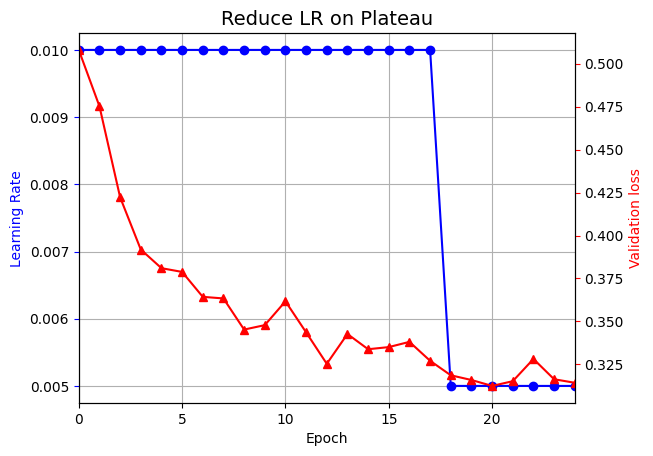

In [88]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color="b")
plt.tick_params("y", color="b")
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel("Validation loss", color="r")
ax2.tick_params("y", color="r")

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle Scheduling

- The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch.
- It multiplies it by a constant `factor`.
- It also saves the learning rate and loss at each batch, each in a list.
- Since `log["loss"]` is actually the mean loss since the start of the epoch, anh we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [89]:
K = tf.keras.backend


class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(
            self.model.optimizer.learning_rate,
            self.model.optimizer.learning_rate * self.factor,
        )

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and the corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [90]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4, max_rate=1):
    init_weights = model.get_weights()
    init_lr = K.get_value(model.optimizer.learning_rate)
    iterations = math.ceil(len(X_train) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [91]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale("log")
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), colors="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [92]:
model = build_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

Now, let's find the optimal learning rate for 1cycle: 

430/430 [==============================] - 2s 3ms/step - loss: 2.9289 - accuracy: 0.2949


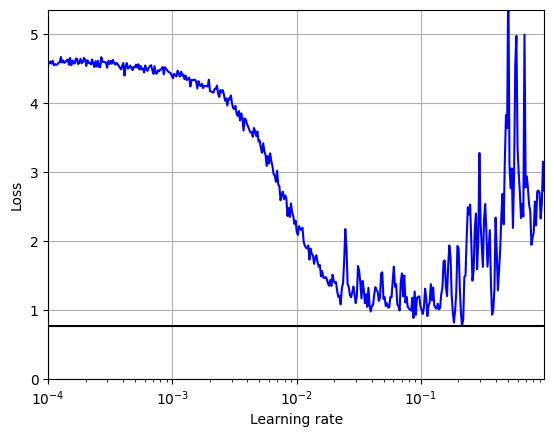

In [93]:
batch_size = 128
rates, losses = find_learning_rate(
    model, X_train, y_train, epochs=1, batch_size=batch_size
)
plot_lr_vs_loss(rates, losses)

Looks like the optimal learning rate to use for 1cycle is about 0.1.

In [94]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(
        self, iterations, max_lr=1e-3, start_lr=None, last_iterations=None, last_lr=None
    ):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iterations = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1: int, iter2: int, lr1: int, lr2: int):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs=None):
        if self.iteration < self.half_iterations:
            lr = self._interpolate(0, self.half_iterations, self.start_lr, self.max_lr)
        elif self.iteration < 2 * self.half_iterations:
            lr = self._interpolate(
                self.half_iterations,
                2 * self.half_iterations,
                self.max_lr,
                self.start_lr,
            )
        else:
            lr = self._interpolate(
                2 * self.half_iterations, self.iterations, self.max_lr, self.last_lr
            )
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Here we build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback.

In [95]:
model = build_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(),
    metrics=["accuracy"],
)
n_epochs = 25
one_cycle = OneCycleScheduler(
    math.ceil(len(X_train) / batch_size) * n_epochs, max_lr=0.1
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[one_cycle],
)

Epoch 1/25
430/430 [==============================] - 2s 3ms/step - loss: 1.2775 - accuracy: 0.6088 - val_loss: 0.6620 - val_accuracy: 0.7690
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6363 - accuracy: 0.7774 - val_loss: 0.5298 - val_accuracy: 0.8122
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.5341 - accuracy: 0.8108 - val_loss: 0.4815 - val_accuracy: 0.8288
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4777 - accuracy: 0.8303 - val_loss: 0.4390 - val_accuracy: 0.8508
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4455 - accuracy: 0.8413 - val_loss: 0.4427 - val_accuracy: 0.8366
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4155 - accuracy: 0.8502 - val_loss: 0.5389 - val_accuracy: 0.7950
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3969 - accuracy: 0.8573 - val_loss: 0.4234 - val_accuracy: 0.8426
Epoch 

# Avoiding Overfitting Through Regularization

In [96]:
layer = tf.keras.layers.Dense(
    100,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
)

or use `l1(0.1)` for $\ell_1$ regularization with a factor of 0.1, or use `l1_l2(0.1, 0.01)` for both $\ell_1$ and $ell_2$, with factors 0.1 and 0.01, respectively.

In [97]:
tf.random.set_seed(42)

In [98]:
from functools import partial

RegularizedDense = partial(
    tf.keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        RegularizedDense(100),
        RegularizedDense(100),
        RegularizedDense(10, activation="softmax"),
    ]
)

In [99]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 2ms/step - loss: 3.1353 - accuracy: 0.7784 - val_loss: 1.8683 - val_accuracy: 0.8238
Epoch 2/2
1719/1719 [==============================] - 3s 2ms/step - loss: 1.4317 - accuracy: 0.8151 - val_loss: 1.1327 - val_accuracy: 0.8160


## Dropout

In [100]:
tf.random.set_seed(42)

In [101]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [102]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6751 - accuracy: 0.7531 - val_loss: 0.4482 - val_accuracy: 0.8292
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5130 - accuracy: 0.8124 - val_loss: 0.4150 - val_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4746 - accuracy: 0.8262 - val_loss: 0.4015 - val_accuracy: 0.8540
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4449 - accuracy: 0.8357 - val_loss: 0.3881 - val_accuracy: 0.8544
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4317 - accuracy: 0.8391 - val_loss: 0.3679 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4238 - accuracy: 0.8440 - val_loss: 0.3645 - val_accuracy: 0.8628
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4125 - accuracy: 0.8480 - val_loss: 0.3626 - val_accuracy:

- The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training.
- If we evaluate the model on the training set after training (e.g., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy.

In [103]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.3210 - accuracy: 0.8779


[0.32101261615753174, 0.8778727054595947]

In [104]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3756 - accuracy: 0.8623


[0.37559354305267334, 0.8622999787330627]

**Note**: Make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural network using SELU.

## MC Dropout

In [105]:
tf.random.set_seed(42)

In [106]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [107]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 41ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.02 , 0.   , 0.371, 0.   ,
        0.609]], dtype=float32)

In [108]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.074, 0.   , 0.355, 0.   ,
       0.569], dtype=float32)

In [109]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.094, 0.   , 0.19 , 0.001,
       0.215], dtype=float32)

In [110]:
y_predict = y_proba.argmax(axis=1)
accuracy = (y_predict == y_test).sum() / len(y_test)
accuracy

0.8653

In [111]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [112]:
# Extra code - shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential(
    [
        MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
        for layer in model.layers
    ]
)
mc_model.set_weights(model.get_weights())

In [113]:
mc_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_89 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_90 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_91 (Dense)            (None, 10)              

Now we can use the model with MC dropout.

In [114]:
# Extra code showing the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1]) for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 11ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.35, 0.  , 0.58]],
      dtype=float32)

## Max norm

In [115]:
dense = tf.keras.layers.Dense(
    100,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.0),
)

In [116]:
# Extra code - explain how to apply max norm to every hidden layer in a model

MaxNormDense = partial(
    tf.keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.0),
)

tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        MaxNormDense(100),
        MaxNormDense(100),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5451 - accuracy: 0.8029 - val_loss: 0.4292 - val_accuracy: 0.8370
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4101 - accuracy: 0.8508 - val_loss: 0.4169 - val_accuracy: 0.8388
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3774 - accuracy: 0.8599 - val_loss: 0.3637 - val_accuracy: 0.8678
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3605 - accuracy: 0.8679 - val_loss: 0.3539 - val_accuracy: 0.8666
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3452 - accuracy: 0.8722 - val_loss: 0.3463 - val_accuracy: 0.8672
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3395 - accuracy: 0.8745 - val_loss: 0.4017 - val_accuracy: 0.8606
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3296 - accuracy: 0.8767 - val_loss: 0.4616 - val_accuracy: